In [10]:

from PIL import Image
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt

from utils.Scorer import Scorer
from utils.Model import Model

In [11]:
PROMPTS = [
    "Make a caption describing the image.",
    "Make a caption describing the image. Be synthetic and mention every notable element such as persons, animals, vehicles, or particularly visible objects on the foreground.",
    "Provide a very short, concise, and factual caption for this image. Maximum 10 words."
    ]

# Images
IMG_FOLDER = Path('../data/coco/val2017')

NUM_IMG = 20
IMGS_PATH = list(IMG_FOLDER.rglob('*.jpg'))[:NUM_IMG]
# Test images
IMG_TEST_PATH = IMGS_PATH[5]
IMG_TEST_ID=int(Path(IMG_TEST_PATH).stem)

# CHAIR
PATH_INSTANCES = "../data/coco/annotations/instances_val2017.json"
PATH_SYNONYMS = "utils/our_data/coco_synonyms_SOTA.txt"

## UTILS

Load captions for each picture.

In [12]:
CAPTIONS_MAP_PATH = "utils\our_data\captions_map.pkl"

if not os.path.exists(CAPTIONS_MAP_PATH):
    print("Fichier introuvable.")
else:
    with open(CAPTIONS_MAP_PATH, "rb") as f:
        coco_captions = pickle.load(f)
        print(f"ground truth captions loaded : {len(coco_captions)}")

ground truth captions loaded : 5000


# Model

In [13]:
model = Model(prompts=PROMPTS,imgs_path=IMGS_PATH,coco_captions=coco_captions)

Demo image test

--- Starting analysis. Selected images : 1 ---
Analyse 0/1 : 785, ..\data\coco\val2017\000000000785.jpg
    Carving the slopes: A winter sports enthusiast in action, taking a thrilling run down the mountain on skis.
Model captions : 
Carving the slopes: A winter sports enthusiast in action, taking a thrilling run down the mountain on skis.


Ground truth captions : 
A woman posing for the camera standing on skis.
a woman standing on skiis while posing for the camera
A woman in a red jacket skiing down a slope
A young woman is skiing down the mountain slope. 
a person on skis makes her way through the snow


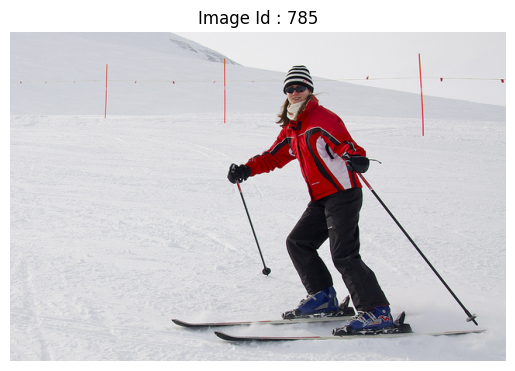

In [14]:
test_model = Model(prompts=PROMPTS,imgs_path=[IMG_TEST_PATH],coco_captions=coco_captions)
test_model_responses,test_gt_captions_dict = test_model.execute(prompt_id=0,freq_print=1)

test_responses = {}
test_responses[IMG_TEST_ID] = []
for val in test_model_responses[IMG_TEST_ID]:
   test_responses[IMG_TEST_ID].append(val)

print(f"Model captions : ")
for str in test_responses[IMG_TEST_ID]:
   print(f"{str}")
print("\n")

print(f"Ground truth captions : ")
for str in test_gt_captions_dict[IMG_TEST_ID]:
   print(f"{str}")

img = Image.open(IMG_TEST_PATH)
plt.imshow(img)
plt.axis('off') # Pour cacher les axes X et Y
plt.title(f"Image Id : {IMG_TEST_ID}")
plt.show()

# METRIQUES

In [15]:
print(test_gt_captions_dict)
print(test_model_responses)

scorer = Scorer(path_instances=PATH_INSTANCES,path_synonyms=PATH_SYNONYMS)

results = scorer.compute_scores(test_gt_captions_dict, test_model_responses)

print("\n--- Résultats Finaux ---")
for metric, score in results.items():
   print(f"{metric}: {score:.4f}")

{785: ['A woman posing for the camera standing on skis.', 'a woman standing on skiis while posing for the camera', 'A woman in a red jacket skiing down a slope', 'A young woman is skiing down the mountain slope. ', 'a person on skis makes her way through the snow']}
{785: ['Carving the slopes: A winter sports enthusiast in action, taking a thrilling run down the mountain on skis.']}
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 18, 'reflen': 10, 'guess': [18, 17, 16, 15], 'correct': [8, 3, 1, 0]}
ratio: 1.79999999982
Calcul de SPICE...
Calcul de CHAIR...

--- Résultats Finaux ---
CIDEr: 0.0000
Bleu_1: 0.4444
Bleu_2: 0.2801
Bleu_3: 0.1699
Bleu_4: 0.0000
SPICE: 0.1143
CHAIR: 0.5000


# Comparer prompts

In [16]:
prompts_scores = {}
for i,prompt in enumerate(PROMPTS):
    prompts_scores[i] = {}
    prompts_scores[i]["prompt"]=prompt

    model_responses,gt_captions_dict = model.execute(prompt_id=i,freq_print=0)
    results = scorer.compute_scores(gt_captions_dict, model_responses)

    for metric, score in results.items():
        prompts_scores[i][metric] = score

--- Starting analysis. Selected images : 20 ---
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 328, 'reflen': 235, 'guess': [328, 308, 288, 268], 'correct': [111, 28, 7, 1]}
ratio: 1.3957446808451246
Calcul de SPICE...
Calcul de CHAIR...
--- Starting analysis. Selected images : 20 ---
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 1599, 'reflen': 253, 'guess': [1599, 1579, 1559, 1539], 'correct': [253, 79, 19, 5]}
ratio: 6.320158102741818
Calcul de SPICE...
Calcul de CHAIR...
--- Starting analysis. Selected images : 20 ---
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 91, 'reflen': 169, 'guess': [91, 71, 51, 31], 'correct': [64, 18, 5, 0]}
ratio: 0.5384615384583523
Calcul de SPICE...
Calcul de CHAIR...


In [17]:
print(prompts_scores)

{0: {'prompt': 'Make a caption describing the image.', 'CIDEr': np.float64(0.2853429553497856), 'Bleu_1': 0.3384146341453097, 'Bleu_2': 0.1753994490880254, 'Bleu_3': 0.09076547136682185, 'Bleu_4': 0.04087020367767122, 'SPICE': np.float64(0.089464447675816), 'CHAIR': 0.46153846153846156}, 1: {'prompt': 'Make a caption describing the image. Be synthetic and mention every notable element such as persons, animals, vehicles, or particularly visible objects on the foreground.', 'CIDEr': np.float64(0.0342778721379199), 'Bleu_1': 0.15822388993110806, 'Bleu_2': 0.08897305633012166, 'Bleu_3': 0.04586430689753482, 'Bleu_4': 0.02366132017334776, 'SPICE': np.float64(0.12874198071292917), 'CHAIR': 0.4426229508196721}, 2: {'prompt': 'Provide a very short, concise, and factual caption for this image. Maximum 10 words.', 'CIDEr': np.float64(0.610777082285928), 'Bleu_1': 0.29846002332668, 'Bleu_2': 0.17919420299594438, 'Bleu_3': 0.11013662798131871, 'Bleu_4': 1.1629078577222994e-05, 'SPICE': np.float64(

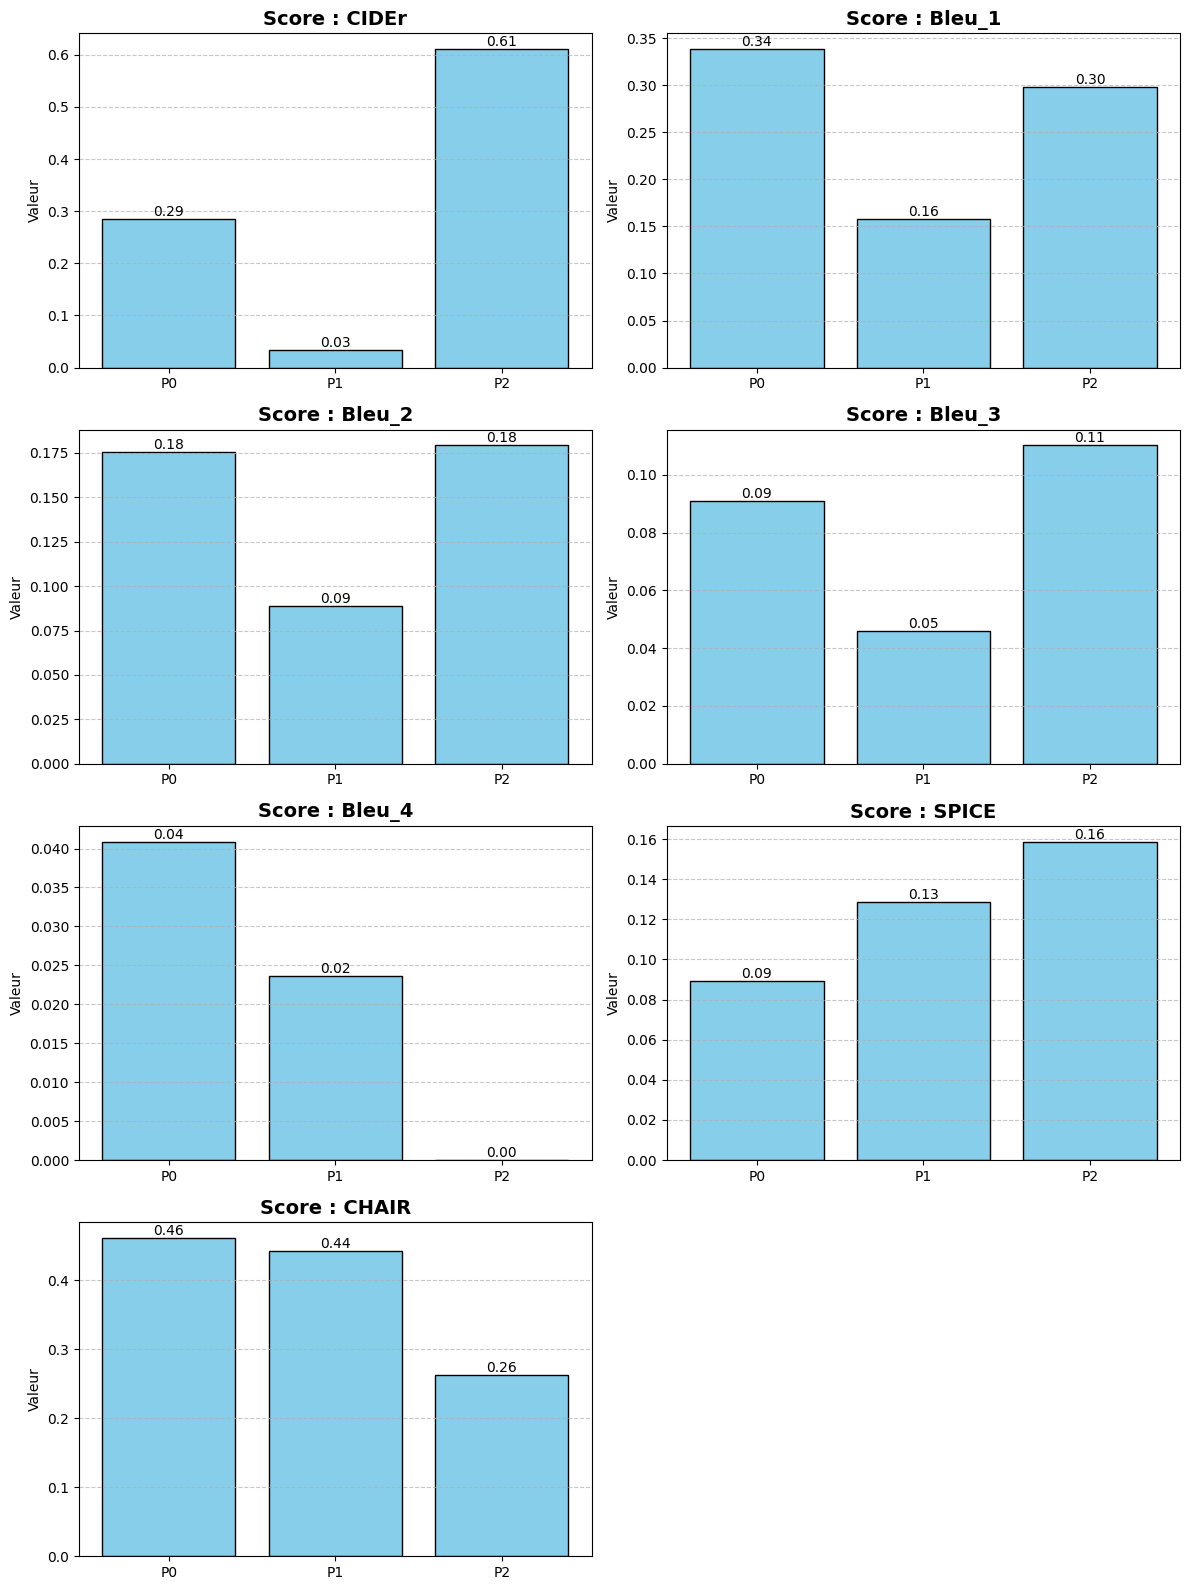

--------------------------------------------------
LÉGENDE DES PROMPTS :
P0 : Make a caption describing the image.
P1 : Make a caption describing the image. Be synthetic and mention every notable element such as persons, animals, vehicles, or particularly visible objects on the foreground.
P2 : Provide a very short, concise, and factual caption for this image. Maximum 10 words.
--------------------------------------------------


In [18]:
import matplotlib.pyplot as plt
import math

def plot_prompt_comparison(data_dict):
    # 1. Extraction des métriques disponibles (on ignore la clé "prompt")
    first_key = next(iter(data_dict))
    metrics = [k for k in data_dict[first_key].keys() if k != 'prompt']
    
    prompt_ids = list(data_dict.keys())
    # On crée des labels courts "P0", "P1" pour l'axe X pour que ce soit lisible
    x_labels = [f"P{i}" for i in prompt_ids]
    
    # 2. Configuration de la grille de subplots
    n_metrics = len(metrics)
    n_cols = 2  # On met 2 graphiques par ligne
    n_rows = math.ceil(n_metrics / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten() # Aplatir pour itérer facilement si n_rows > 1

    # 3. Boucle sur chaque métrique
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Récupération des scores pour cette métrique pour tous les prompts
        scores = [data_dict[pid][metric] for pid in prompt_ids]
        
        # Création des barres
        bars = ax.bar(x_labels, scores, color='skyblue', edgecolor='black')
        
        # Esthétique
        ax.set_title(f"Score : {metric}", fontsize=14, fontweight='bold')
        ax.set_ylabel("Valeur")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Ajouter la valeur numérique au dessus de la barre
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

    # Masquer les axes vides s'il y en a (ex: 5 métriques sur une grille de 6)
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    # 4. Affichage de la légende des prompts en texte
    print("-" * 50)
    print("LÉGENDE DES PROMPTS :")
    for pid in prompt_ids:
        p_text = data_dict[pid]['prompt']
        # On coupe si c'est trop long pour l'affichage
        print(f"P{pid} : {p_text}")
    print("-" * 50)

# Appel de la fonction
plot_prompt_comparison(prompts_scores)